In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm as cm
import community.community_louvain as cl
import community
from sklearn.cluster import SpectralClustering

In [2]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', '#768695', d_color, '#50dcff', '#ffa30e', '#ffe72f', '#f43131', '#ff9ad2', '#2ca02c', '#a8ee72', '#795133', '#c98d66']

In [3]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [24]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [25]:
movies_subset = movies[movies.Year >= 2000]
df_movies_subset = movies_subset[movies_subset.Name.isin(credits.title)] #movies that are in credits
df_tmdb = tmdb_movies[tmdb_movies.title.isin(df_movies_subset.Name)]#movies that are also in the other movie data set

#remove movies, where there are either/or not genres, keywords or tagline
df_tmdb = df_tmdb[df_tmdb.genres != '[]']
df_tmdb = df_tmdb[df_tmdb.keywords != '[]']
df_tmdb = df_tmdb[df_tmdb.tagline.notnull()].reset_index()

In [26]:
df_credits = credits[credits.movie_id.isin(df_tmdb.id)]

---
# **Movie network**
---
- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [29]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 10 actors
    actors = [actor['name'] for actor in cast[:3]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    
    # Number of common actors
    common_actors = len(set(actors1) & set(actors2))
    
    # If they have at least x common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


In [30]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

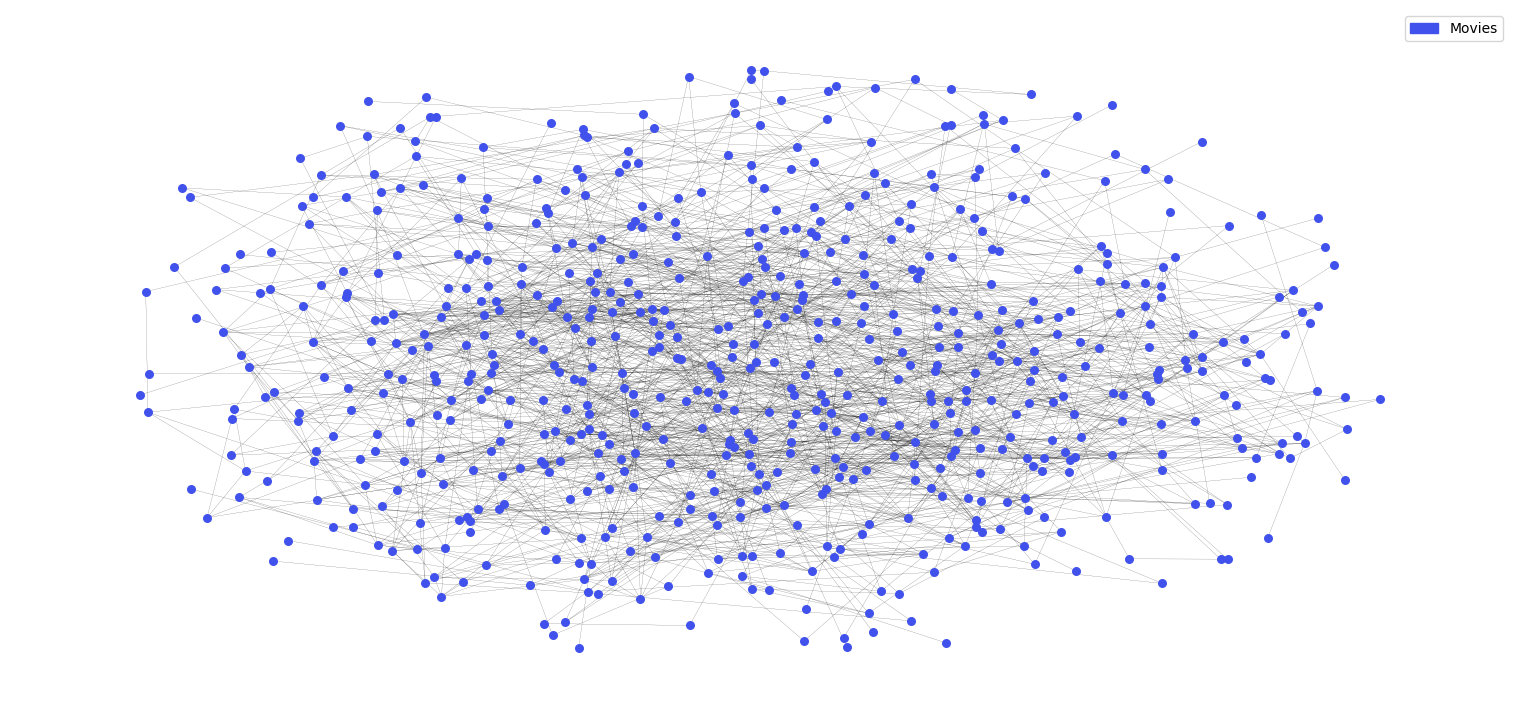

In [31]:
# Layout
plt.figure(figsize=(15, 7))
# pos = nx.spring_layout(G_movies_lcc)
pos = nx.spring_layout(G_movies_lcc, k=0.3)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])
plt.show()

In [32]:
n_nodes = len(G_movies_lcc.nodes())
n_edges = len(G_movies_lcc.edges())
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 644
Number of edges: 2093


## **Communities**

In [33]:
# Girvan–Newman algorithm
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies_lcc)
nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies_lcc)
nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
num_communities = len(nx_best_community)
nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies_lcc, nx_best_community)

print("Girvan–Newman:")
print("\t- Number of communities found by Girvan-Newman:", num_communities)
print("\t- Modularity:", round(nx_modularity_G,2))

Girvan–Newman:
	- Number of communities found by Girvan-Newman: 2
	- Modularity: 0.01


In [36]:
# Louvain algorithm
communities_Louvain = cl.best_partition(G_movies_lcc, random_state=seed)
n_communities_Louvain = len(np.unique(list(communities_Louvain.values())))
modularity_Louvain = community.modularity(communities_Louvain, G_movies_lcc)

print("Louvain:")
print("\t- Number of communities found by Louvain:", n_communities_Louvain)
print("\t- Modularity:", round(modularity_Louvain,2))

Louvain:
	- Number of communities found by Louvain: 17
	- Modularity: 0.65


In [12]:
# Spectral clustering - Choosing random number of clusters
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
sc = SpectralClustering(35, affinity='precomputed', n_init=100)
sc.fit(adj_mat)
nodes = list(G_movies_lcc.nodes())
communities_Spectral = communities_Spectral = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(sc.n_clusters)]
n_communities_Spectral = len(communities_Spectral) 
modularity_Spectral = nx.algorithms.community.quality.modularity(G_movies_lcc, communities_Spectral)

print("Spectral clustering:")
print("\t- Number of communities found with spectral clustering:", n_communities_Spectral)
print("\t- Modularity:", round(modularity_Spectral,2))

c:\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Spectral clustering:
	- Number of communities found with spectral clustering: 35
	- Modularity: 0.58


In [13]:
# Spectral clustering - Finding the best number of clusters 
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
nodes = list(G_movies_lcc.nodes())

best_modularity = -np.inf
best_n_clusters = None
best_communities = None

# Try different numbers of clusters
for n_clusters in range(2, 100):
    sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    # Convert labels array to list of sets format
    communities = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(n_clusters)]
    modularity = nx.algorithms.community.quality.modularity(G_movies_lcc, communities)

    # Update
    if modularity > best_modularity:
        best_modularity = modularity
        best_n_clusters = n_clusters
        best_communities = communities

print("Best modularity is", best_modularity, "found with", best_n_clusters, "clusters.")
# Approx 3:33 min to run

Best modularity is 0.586163382877066 found with 35 clusters.


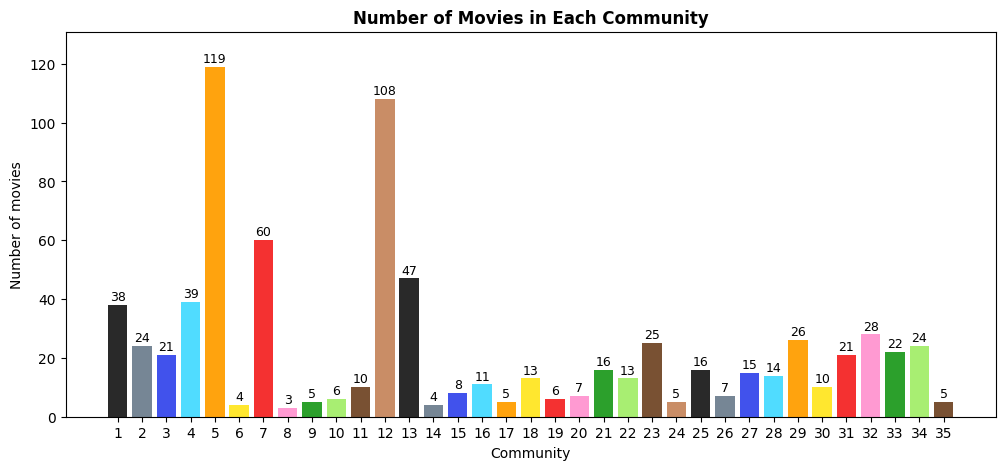

In [14]:
# Number of movies in each community
num_movies = [len(community) for community in best_communities]

# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, best_n_clusters + 1), num_movies, color=[colors[i % len(colors)] for i in range(best_n_clusters)])
plt.xticks(range(1, best_n_clusters + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel('Community')
plt.ylabel('Number of movies')
plt.title('Number of Movies in Each Community', fontweight='bold')

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

plt.show()

12


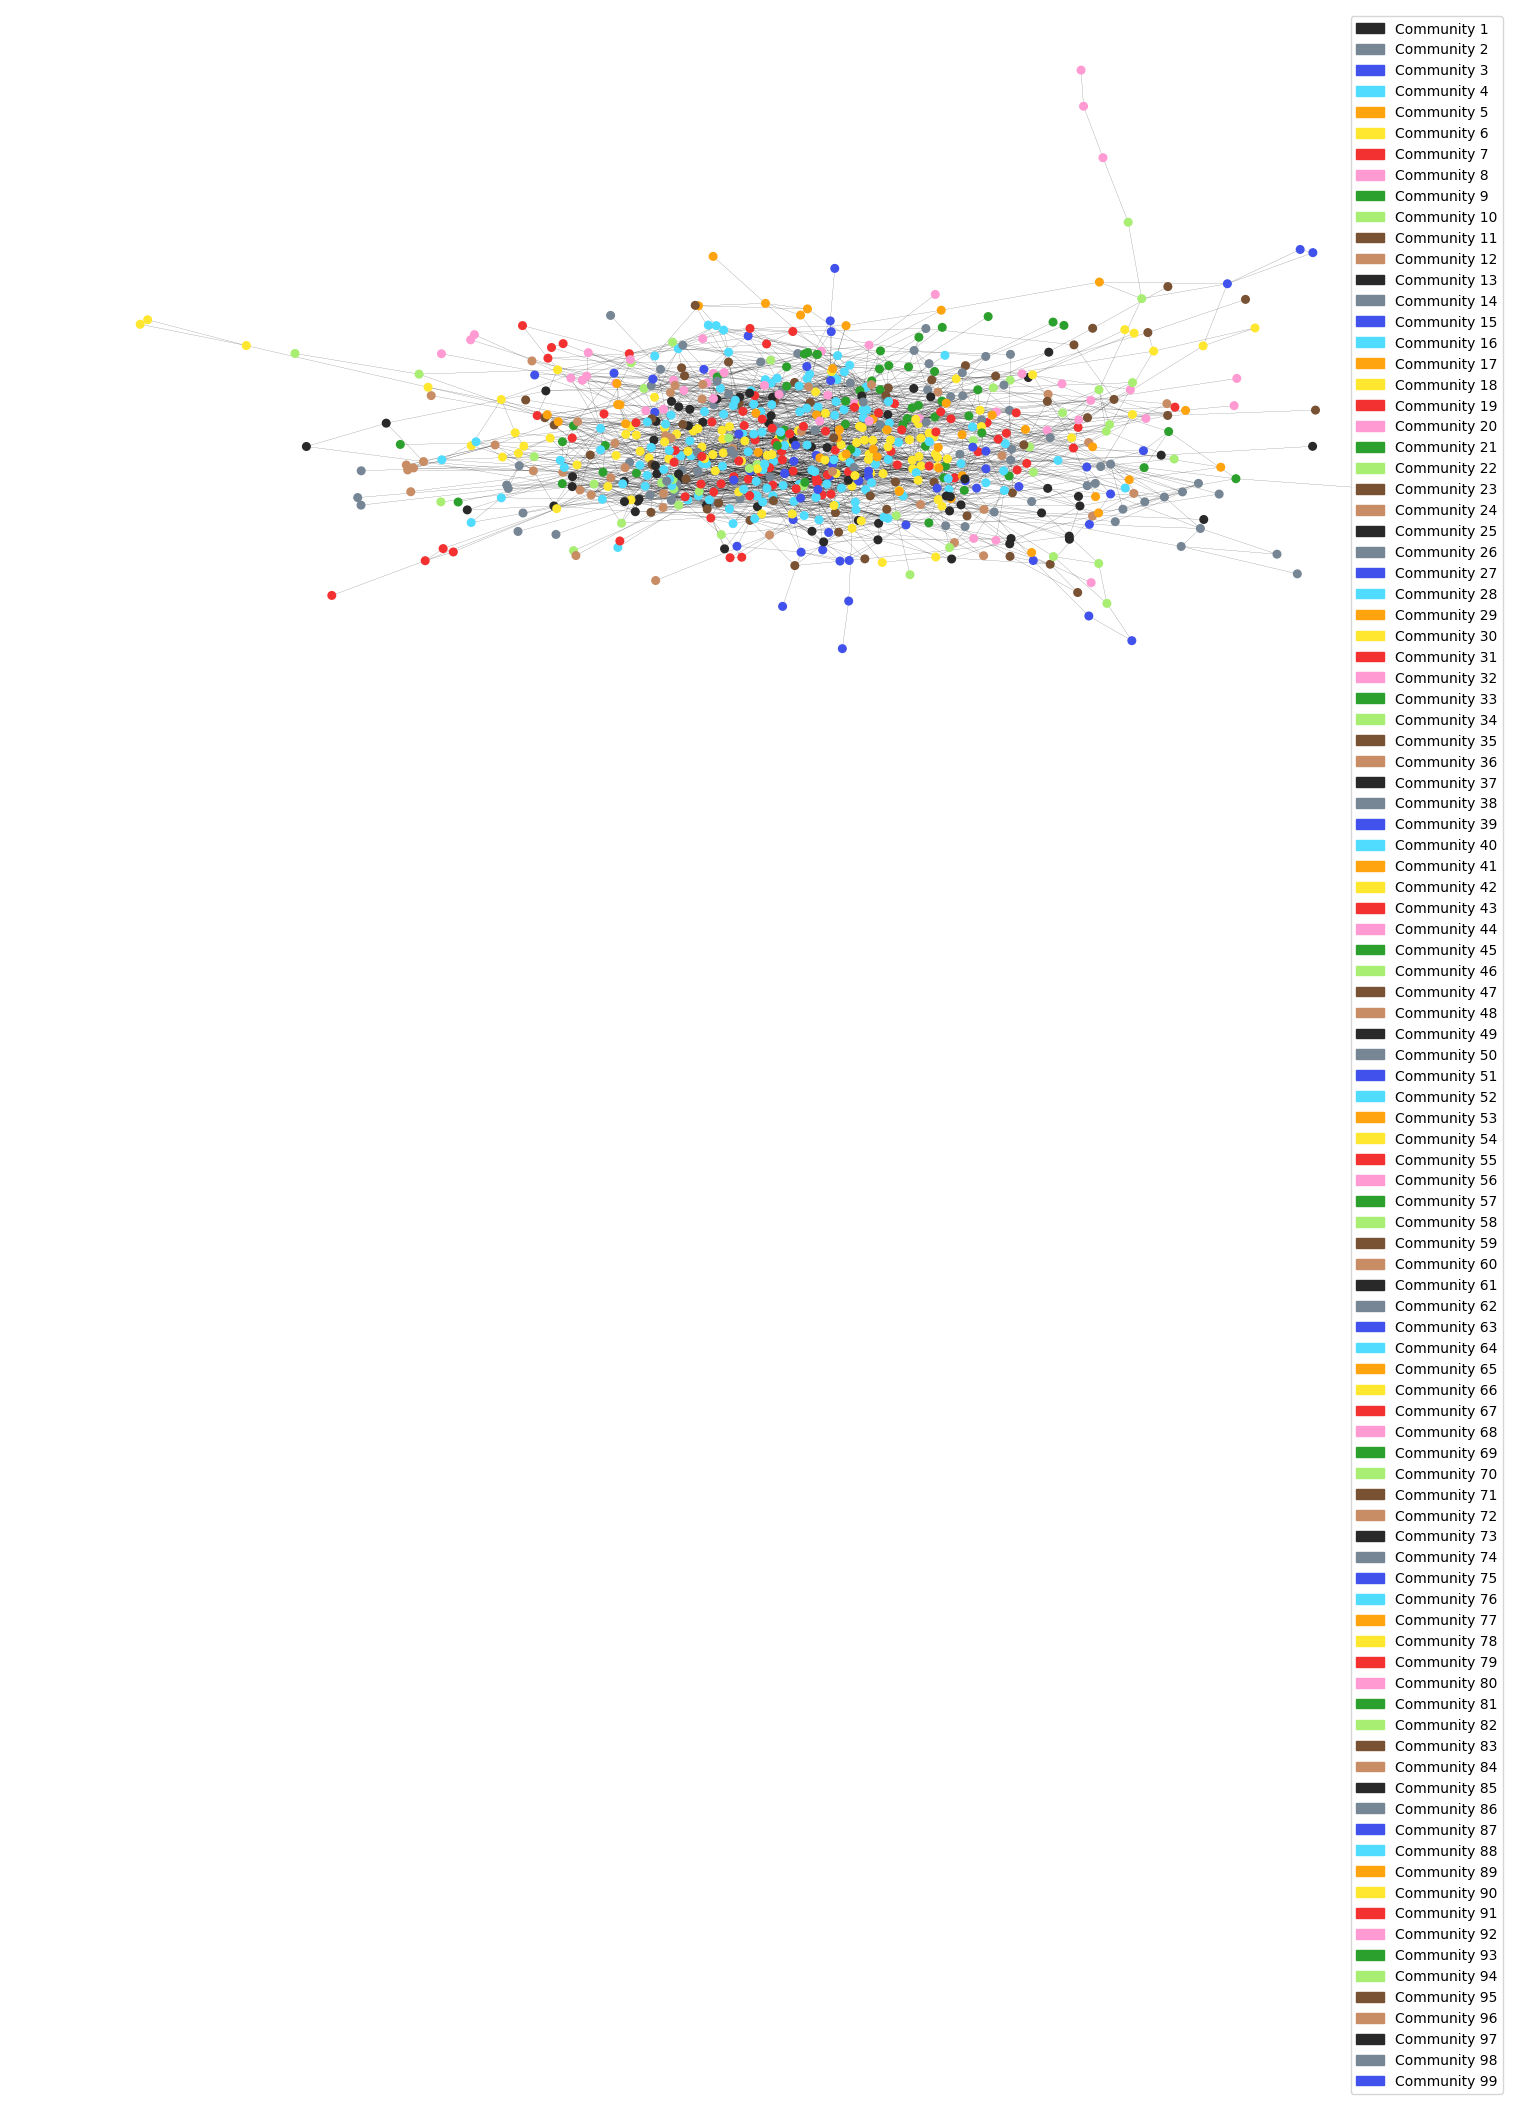

In [15]:
# Communities
communities2 = nx.algorithms.community.greedy_modularity_communities(G_movies_lcc)
n_communities = len(np.unique(list(communities2)))
print(n_communities)

# Plot
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)
color_map = {node: colors[i % len(colors)] for i, community in enumerate(communities) for node in community}
nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color='black', with_labels=False, node_size=30, width=0.1)
patches = [mpatches.Patch(color=colors[i % len(colors)], label=f'Community {i+1}') for i in range(len(communities))]
plt.legend(handles=patches)
plt.show()


In [16]:
# Number of Movies in Each Community
for i, community in enumerate(communities, start=1):
    print(f'Community {i}: \t {len(community)} movies')

Community 1: 	 9 movies
Community 2: 	 15 movies
Community 3: 	 2 movies
Community 4: 	 21 movies
Community 5: 	 3 movies
Community 6: 	 3 movies
Community 7: 	 4 movies
Community 8: 	 3 movies
Community 9: 	 16 movies
Community 10: 	 2 movies
Community 11: 	 13 movies
Community 12: 	 3 movies
Community 13: 	 2 movies
Community 14: 	 4 movies
Community 15: 	 3 movies
Community 16: 	 14 movies
Community 17: 	 4 movies
Community 18: 	 3 movies
Community 19: 	 22 movies
Community 20: 	 8 movies
Community 21: 	 6 movies
Community 22: 	 3 movies
Community 23: 	 2 movies
Community 24: 	 5 movies
Community 25: 	 5 movies
Community 26: 	 12 movies
Community 27: 	 5 movies
Community 28: 	 3 movies
Community 29: 	 5 movies
Community 30: 	 68 movies
Community 31: 	 7 movies
Community 32: 	 3 movies
Community 33: 	 3 movies
Community 34: 	 3 movies
Community 35: 	 2 movies
Community 36: 	 8 movies
Community 37: 	 5 movies
Community 38: 	 4 movies
Community 39: 	 3 movies
Community 40: 	 7 movies
C

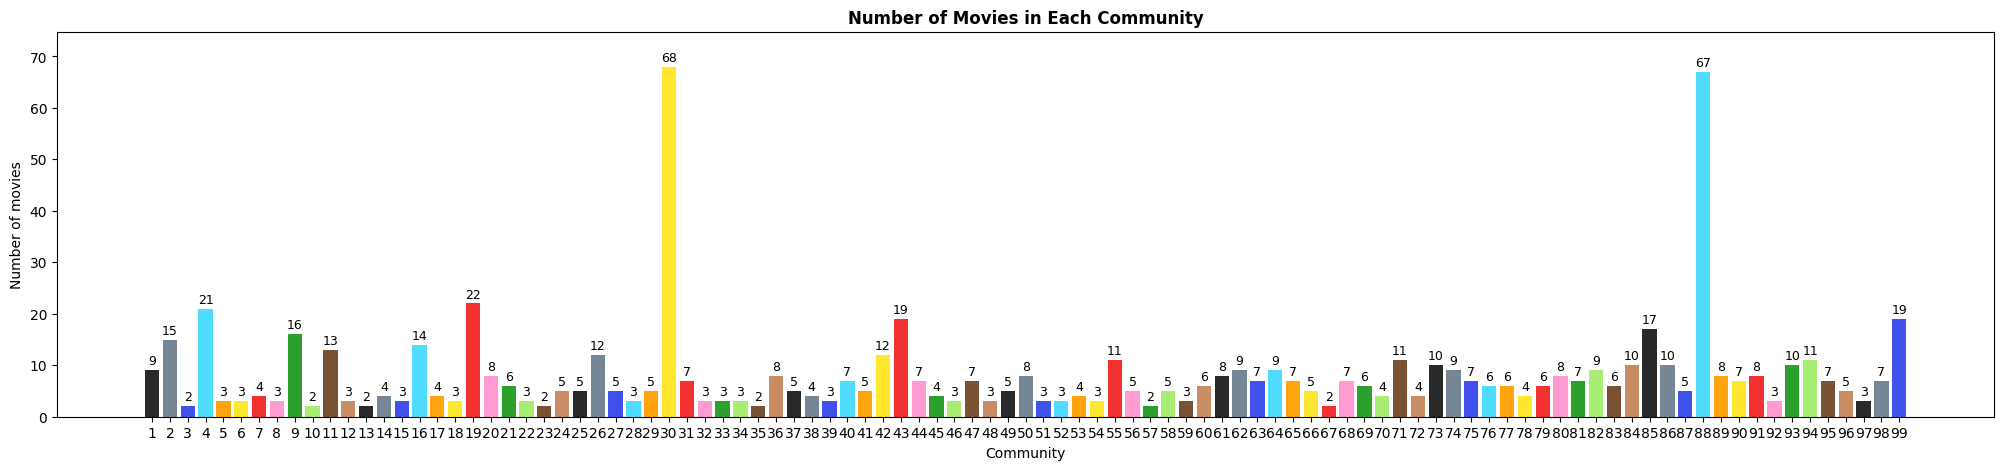

In [38]:
# Number of movies in each community
num_movies = [len(community) for community in communities]

# Histogram
plt.figure(figsize=(25, 5))
bars = plt.bar(range(1, len(communities) + 1), num_movies, color=[colors[i % len(colors)] for i in range(len(communities))])
plt.xticks(range(1, len(communities) + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel('Community')
plt.ylabel('Number of movies')
plt.title('Number of Movies in Each Community', fontweight='bold')

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

plt.show()


In [18]:
# Number of Movies in Each Community and their titles
for i, community in enumerate(communities, start=1):
    print(f'Community {i}:')
    for movie in community:
        print(f'\t- {movie}')
    print('\n')


Community 1:
	- Under the Tuscan Sun
	- Unfaithful
	- The Perfect Storm
	- Exorcist: The Beginning
	- Hollow Man
	- My Dog Skip
	- Hardball
	- Aberdeen
	- The Glass House


Community 2:
	- The Watcher
	- We Were Soldiers
	- Stranded
	- Signs
	- Get Carter
	- Auto Focus
	- The Patriot
	- Alfie
	- Parental Guidance
	- The Guru
	- Chicken Run
	- The Singing Detective
	- What Women Want
	- Mean Creek
	- Brother


Community 3:
	- Seed of Chucky
	- Home on the Range


Community 4:
	- American Outlaws
	- Coach Carter
	- The Incredibles
	- Hart's War
	- Changing Lanes
	- The Kid
	- Phone Booth
	- The Whole Nine Yards
	- Shaft
	- Unbreakable
	- The Caveman's Valentine
	- Minority Report
	- The Whole Ten Yards
	- A Home at the End of the World
	- Hostage
	- Juwanna Mann
	- Serving Sara
	- Tears of the Sun
	- Glitter
	- S.W.A.T.
	- Bandits


Community 5:
	- X-Men
	- Star Trek: Nemesis
	- The Master of Disguise


Community 6:
	- Igby Goes Down
	- Cats & Dogs
	- The Ring Two


Community 7:
	- A Cin

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [19]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Men of Honor: 22
Shark Tale: 21
Meet the Fockers: 19
Meet the Parents: 19
The Score: 17
Basic: 17
Reindeer Games: 17
Nurse Betty: 17
Ocean's Eleven: 16
Cold Mountain: 16


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [20]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

Shark Tale: 0.02123768542777227
Nurse Betty: 0.01936080135406603
The Hunted: 0.013486392962098654
My Dog Skip: 0.013252390335617396
Cold Mountain: 0.013209503444914233
Men of Honor: 0.013131194583940537
High Crimes: 0.013073737841611787
Quills: 0.012297079127874724
Vanilla Sky: 0.012245511180471135
Mona Lisa Smile: 0.011975498332359216


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [21]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies[:10] 

    return top_movies

In [22]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [23]:
print_movie_community("Basic Instinct 2", communities)

"Basic Instinct 2" is not found in any community.
